In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from pandas.tools.plotting import scatter_matrix

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold

# Class, for use in pipelines, to select certain columns from a DataFrame and convert to a numpy array
# From A. Geron: Hands-On Machine Learning with Scikit-Learn & TensorFlow, O'Reilly, 2017
# Modified by Derek Bridge to allow for casting in the same ways as pandas.DatFrame.astype
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names, dtype=None):
        self.attribute_names = attribute_names
        self.dtype = dtype
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_selected = X[self.attribute_names]
        if self.dtype:
            return X_selected.astype(self.dtype).values
        return X_selected.values

# Class, for use in pipelines, to binarize nominal-valued features (while avoiding the dummy variabe trap)
# By Derek Bridge, 2017
class FeatureBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self, features_values):
        self.features_values = features_values
        self.num_features = len(features_values)
        self.labelencodings = [LabelEncoder().fit(feature_values) for feature_values in features_values]
        self.onehotencoder = OneHotEncoder(sparse=False,
            n_values=[len(feature_values) for feature_values in features_values])
        self.last_indexes = np.cumsum([len(feature_values) - 1 for feature_values in self.features_values])
    def fit(self, X, y=None):
        for i in range(0, self.num_features):
            X[:, i] = self.labelencodings[i].transform(X[:, i])
        return self.onehotencoder.fit(X)
    def transform(self, X, y=None):
        for i in range(0, self.num_features):
            X[:, i] = self.labelencodings[i].transform(X[:, i])
        onehotencoded = self.onehotencoder.transform(X)
        return np.delete(onehotencoded, self.last_indexes, axis=1)
    def fit_transform(self, X, y=None):
        onehotencoded = self.fit(X).transform(X)
        return np.delete(onehotencoded, self.last_indexes, axis=1)
    def get_params(self, deep=True):
        return {"features_values" : self.features_values}
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            self.setattr(parameter, value)
        return self

# Class, for use in pipelines, to impute missing values but which overcomes a problem that scikit-learn's class has
# when imputing modes on nominal-valued features
# From https://stackoverflow.com/questions/25239958/impute-categorical-missing-values-in-scikit-learn
# Original has a casting problem
# Fixed by Derek Bridge 2017
class MissingValueImputer(Imputer):
    def __init__(self, **kwargs):
        Imputer.__init__(self, **kwargs)
    def fit(self, X, y=None):
        if self.strategy == "most_frequent":
            self.fills = pd.DataFrame(X).mode(axis=0).squeeze() 
            return self
        else:
            return Imputer.fit(self, X, y=y)
    def transform(self, X):
        if hasattr(self, "fills"):
            return pd.DataFrame(X).fillna(self.fills).values
        else:
            return Imputer.transform(self, X)

In [5]:
df = pd.read_csv('datasets/dataset_mpg.csv')

In [6]:
df.shape

(398, 8)

In [7]:
df.columns

Index(['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration',
       'year', 'origin', 'mpg'],
      dtype='object')

In [8]:
df.describe(include='all')

,cylinders,displacement,horsepower,weight,acceleration,year,origin,mpg
count,398.000000,398.000000,398,398.000000,398.000000,398.000000,398.000000,398.000000
unique,NaN,NaN,94,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,150.0,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,22,NaN,NaN,NaN,NaN,NaN
mean,5.454774,193.425879,NaN,2970.424623,15.568090,76.010050,1.572864,23.514573
std,1.701004,104.269838,NaN,846.841774,2.757689,3.697627,0.802055,7.815984
min,3.000000,68.000000,NaN,1613.000000,8.000000,70.000000,1.000000,9.000000
25%,4.000000,104.250000,NaN,2223.750000,13.825000,73.000000,1.000000,17.500000
50%,4.000000,148.500000,NaN,2803.500000,15.500000,76.000000,1.000000,23.000000
75%,8.000000,262.000000,NaN,3608.000000,17.175000,79.000000,2.000000,29.000000


In [9]:
df

,cylinders,displacement,horsepower,weight,acceleration,year,origin,mpg
0,8,307.0,130.0,3504.0,12.0,70,1,18.0
1,8,350.0,165.0,3693.0,11.5,70,1,15.0
2,8,318.0,150.0,3436.0,11.0,70,1,18.0
3,8,304.0,150.0,3433.0,12.0,70,1,16.0
4,8,302.0,140.0,3449.0,10.5,70,1,17.0
5,8,429.0,198.0,4341.0,10.0,70,1,15.0
6,8,454.0,220.0,4354.0,9.0,70,1,14.0
7,8,440.0,215.0,4312.0,8.5,70,1,14.0
8,8,455.0,225.0,4425.0,10.0,70,1,14.0
9,8,390.0,190.0,3850.0,8.5,70,1,15.0


/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  """Entry point for launching an IPython kernel.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f97493ed940>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f974841f438>]], dtype=object)

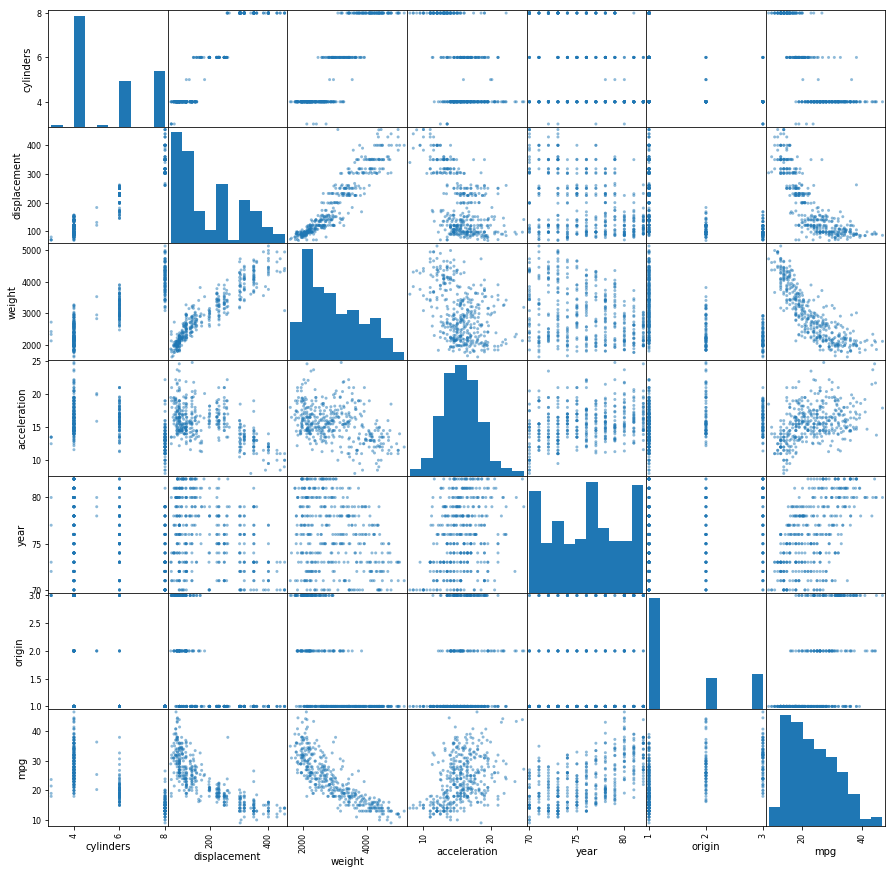

In [10]:
scatter_matrix(df, figsize=(15, 15))

In [11]:
df.dtypes

cylinders         int64
displacement    float64
horsepower       object
weight          float64
acceleration    float64
year              int64
origin            int64
mpg             float64
dtype: object

In [12]:
df['horsepower'].unique()

array(['130.0', '165.0', '150.0', '140.0', '198.0', '220.0', '215.0',
       '225.0', '190.0', '170.0', '160.0', '95.0', '97.0', '85.0', '88.0',
       '46.0', '87.0', '90.0', '113.0', '200.0', '210.0', '193.0', '?',
       '100.0', '105.0', '175.0', '153.0', '180.0', '110.0', '72.0',
       '86.0', '70.0', '76.0', '65.0', '69.0', '60.0', '80.0', '54.0',
       '208.0', '155.0', '112.0', '92.0', '145.0', '137.0', '158.0',
       '167.0', '94.0', '107.0', '230.0', '49.0', '75.0', '91.0', '122.0',
       '67.0', '83.0', '78.0', '52.0', '61.0', '93.0', '148.0', '129.0',
       '96.0', '71.0', '98.0', '115.0', '53.0', '81.0', '79.0', '120.0',
       '152.0', '102.0', '108.0', '68.0', '58.0', '149.0', '89.0', '63.0',
       '48.0', '66.0', '139.0', '103.0', '125.0', '133.0', '138.0',
       '135.0', '142.0', '77.0', '62.0', '132.0', '84.0', '64.0', '74.0',
       '116.0', '82.0'], dtype=object)

In [13]:
#first we should see how many ? are
(df['horsepower'] == '?').sum()

6

In [14]:
df['cylinders'].unique()

array([8, 4, 6, 3, 5])

In [15]:
df['displacement'].unique()

array([ 307. ,  350. ,  318. ,  304. ,  302. ,  429. ,  454. ,  440. ,
        455. ,  390. ,  383. ,  340. ,  400. ,  113. ,  198. ,  199. ,
        200. ,   97. ,  110. ,  107. ,  104. ,  121. ,  360. ,  140. ,
         98. ,  232. ,  225. ,  250. ,  351. ,  258. ,  122. ,  116. ,
         79. ,   88. ,   71. ,   72. ,   91. ,   97.5,   70. ,  120. ,
         96. ,  108. ,  155. ,   68. ,  114. ,  156. ,   76. ,   83. ,
         90. ,  231. ,  262. ,  134. ,  119. ,  171. ,  115. ,  101. ,
        305. ,   85. ,  130. ,  168. ,  111. ,  260. ,  151. ,  146. ,
         80. ,   78. ,  105. ,  131. ,  163. ,   89. ,  267. ,   86. ,
        183. ,  141. ,  173. ,  135. ,   81. ,  100. ,  145. ,  112. ,
        181. ,  144. ])

In [16]:
df['weight'].unique()

array([ 3504.,  3693.,  3436.,  3433.,  3449.,  4341.,  4354.,  4312.,
        4425.,  3850.,  3563.,  3609.,  3761.,  3086.,  2372.,  2833.,
        2774.,  2587.,  2130.,  1835.,  2672.,  2430.,  2375.,  2234.,
        2648.,  4615.,  4376.,  4382.,  4732.,  2264.,  2228.,  2046.,
        2634.,  3439.,  3329.,  3302.,  3288.,  4209.,  4464.,  4154.,
        4096.,  4955.,  4746.,  5140.,  2962.,  2408.,  3282.,  3139.,
        2220.,  2123.,  2074.,  2065.,  1773.,  1613.,  1834.,  1955.,
        2278.,  2126.,  2254.,  2226.,  4274.,  4385.,  4135.,  4129.,
        3672.,  4633.,  4502.,  4456.,  4422.,  2330.,  3892.,  4098.,
        4294.,  4077.,  2933.,  2511.,  2979.,  2189.,  2395.,  2288.,
        2506.,  2164.,  2100.,  4100.,  3988.,  4042.,  3777.,  4952.,
        4363.,  4237.,  4735.,  4951.,  3821.,  3121.,  3278.,  2945.,
        3021.,  2904.,  1950.,  4997.,  4906.,  4654.,  4499.,  2789.,
        2279.,  2401.,  2379.,  2124.,  2310.,  2472.,  2265.,  4082.,
      

In [17]:
#drop the elements where horsepower is '?'
df = (df[df['horsepower']!='?']).copy()
df.reset_index(drop=True, inplace=True)

In [18]:
df.shape


(392, 8)

In [19]:
df['horsepower'] = pd.to_numeric(df['horsepower'])

In [20]:
df['origin'] = df['origin'].astype(object)

In [21]:
df.dtypes

cylinders         int64
displacement    float64
horsepower      float64
weight          float64
acceleration    float64
year              int64
origin            int64
mpg             float64
dtype: object

In [22]:
df.describe(include='all')

,cylinders,displacement,horsepower,weight,acceleration,year,origin,mpg
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531,23.445918
std,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518,7.805007
min,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000,9.000000
25%,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000,17.000000
50%,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000,22.750000
75%,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000,29.000000
max,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000,46.600000


In [23]:
#shuffle the data
df=df.take(np.random.permutation(len(df)))

In [30]:
numeric_features = ["cylinders","displacement","horsepower","weight","acceleration","year"]
nominal_features = ["origin"]

numeric_pipeline = Pipeline([
        ("selector", DataFrameSelector(numeric_features))
    ])

nominal_pipeline = Pipeline([
        ("selector", DataFrameSelector(nominal_features)), 
        ("binarizer", FeatureBinarizer([df[feature].unique() for feature in nominal_features]))])

pipeline = Pipeline([("union", FeatureUnion([("numeric_pipeline", numeric_pipeline), 
                                             ("nominal_pipeline", nominal_pipeline)])),
                         ("estimator", LinearRegression())])
#I not include a scaler in pipeline because LinearRegression use normal equation



In [25]:
numeric_features_with_origin = ["cylinders","displacement","horsepower","weight","acceleration","year","origin"]

numeric_pipeline = Pipeline([
        ("selector", DataFrameSelector(numeric_features_with_origin)),
        ("estimator", LinearRegression())
    ])

In [26]:
y = df['mpg'].values

In [27]:
#origin as a numeric value
np.mean(cross_val_score(numeric_pipeline, df, y, scoring="neg_mean_absolute_error", cv=10))

-2.5726846173084126

In [31]:
#origin as an object value
np.mean(cross_val_score(pipeline, df, y, scoring="neg_mean_absolute_error", cv=10))

-2.5837749216734665

We notice only a little change in the final result.